$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/thaer/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/thaer/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/thaer/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


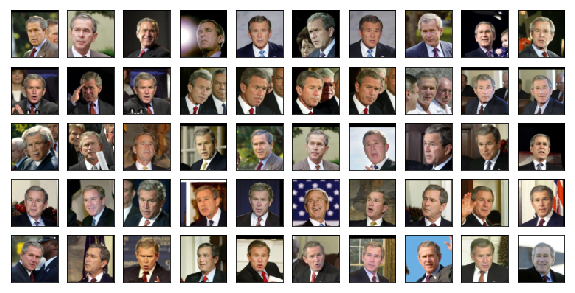

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

torch.Size([3, 64, 64])
Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

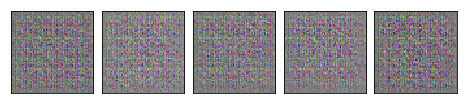

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

torch.Size([3, 64, 64])
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.26it/s]
Discriminator loss: 0.4022838762577842
Generator loss:     3.6342799803789925


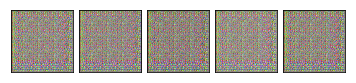

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.24it/s]
Discriminator loss: 0.060317304560585934
Generator loss:     6.479255900663488


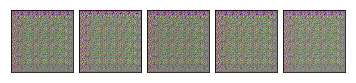

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.26it/s]
Discriminator loss: 0.03782639088218703
Generator loss:     7.151635422426112


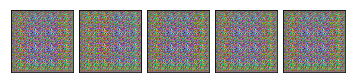

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.15it/s]
Discriminator loss: 0.022160114939598477
Generator loss:     7.7161625132841225


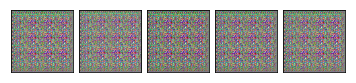

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.27it/s]
Discriminator loss: 0.027402905089890257
Generator loss:     7.482312258552103


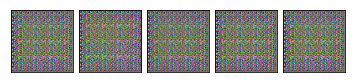

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.06it/s]
Discriminator loss: 0.043317326399333334
Generator loss:     9.89507178699269


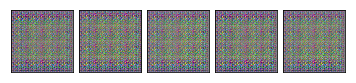

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.31it/s]
Discriminator loss: 0.0221371830386274
Generator loss:     7.749110249912038


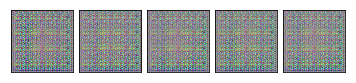

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.26it/s]
Discriminator loss: 0.0246672196971143
Generator loss:     8.034614478840547


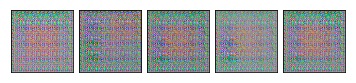

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.45it/s]
Discriminator loss: 0.023247391862027785
Generator loss:     9.69900504280539


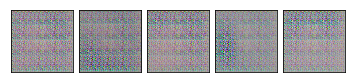

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.07it/s]
Discriminator loss: 0.0029995923533159144
Generator loss:     11.594942738028134


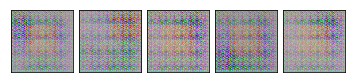

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.02it/s]
Discriminator loss: 0.028653493151068687
Generator loss:     7.9471767088946175


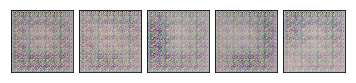

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.14it/s]
Discriminator loss: 0.0272491575930925
Generator loss:     8.102576536290785


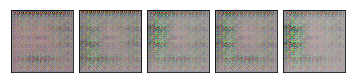

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.71it/s]
Discriminator loss: -0.014067287228124984
Generator loss:     8.62743439393885


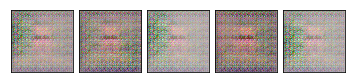

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.34it/s]
Discriminator loss: -0.010119837270501782
Generator loss:     9.86256114174338


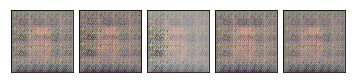

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.35it/s]
Discriminator loss: 0.02586004406432895
Generator loss:     8.529943746678969


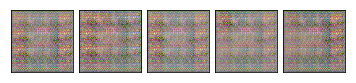

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.13it/s]
Discriminator loss: 0.034082081497592086
Generator loss:     7.517268180847168


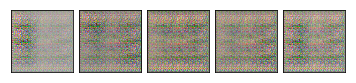

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.24it/s]
Discriminator loss: 0.01741193958065089
Generator loss:     8.549176188076244


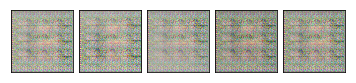

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.45it/s]
Discriminator loss: 0.01591136438005111
Generator loss:     12.289215985466452


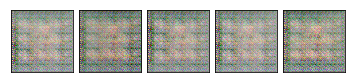

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.11it/s]
Discriminator loss: 0.021831633413539213
Generator loss:     12.017369522767908


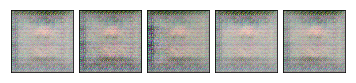

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.51it/s]
Discriminator loss: 0.044148648595985246
Generator loss:     11.444228452794691


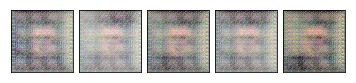

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.06it/s]
Discriminator loss: 0.04460623887751032
Generator loss:     9.658961800967946


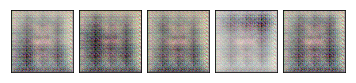

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.11it/s]
Discriminator loss: 0.03852704238584813
Generator loss:     8.985782483044792


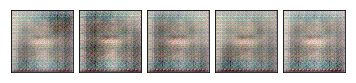

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.84it/s]
Discriminator loss: 0.02146548087544301
Generator loss:     9.652920218075023


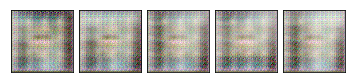

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.46it/s]
Discriminator loss: 0.07703010562588186
Generator loss:     12.977922944461598


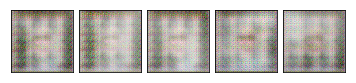

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.38it/s]
Discriminator loss: 0.05186936664668953
Generator loss:     9.10474510753856


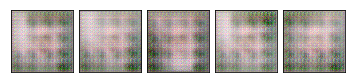

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.04818831110263572
Generator loss:     9.511353156145882


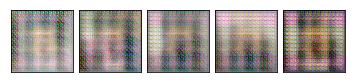

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.052439905483933055
Generator loss:     7.823462850907269


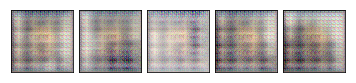

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
Discriminator loss: 0.01880163756911369
Generator loss:     9.437497110927806


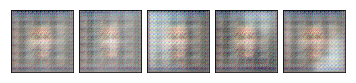

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.19it/s]
Discriminator loss: 0.08108953079756569
Generator loss:     12.201773110558005


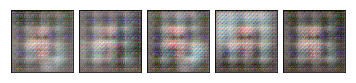

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.97it/s]
Discriminator loss: 0.07465962216477184
Generator loss:     8.944892518660602


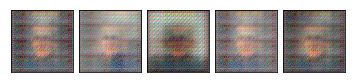

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.09it/s]
Discriminator loss: 0.10846161968348657
Generator loss:     10.04673220129574


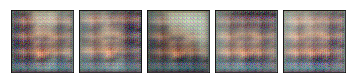

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.13it/s]
Discriminator loss: 0.046988626996822214
Generator loss:     8.177918349995332


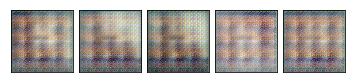

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.18it/s]
Discriminator loss: 0.08862899304093684
Generator loss:     10.522600903230554


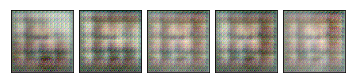

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.19it/s]
Discriminator loss: 0.03626178237883484
Generator loss:     9.881071960224824


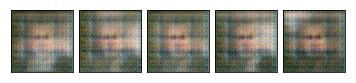

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.44it/s]
Discriminator loss: 0.055667064864845836
Generator loss:     7.367160741020651


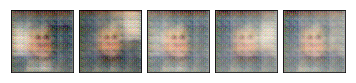

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.46it/s]
Discriminator loss: 0.06483911109321258
Generator loss:     10.38596804001752


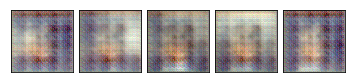

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.06it/s]
Discriminator loss: 0.058702757143798995
Generator loss:     11.708405719083899


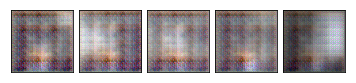

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
Discriminator loss: 0.02440410994869821
Generator loss:     8.158684618332806


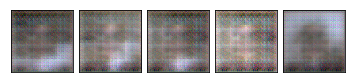

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.22it/s]
Discriminator loss: 0.046541558797745144
Generator loss:     7.462915841270895


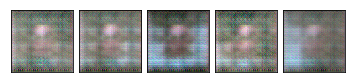

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
Discriminator loss: 0.03760329162811532
Generator loss:     8.998805803411146


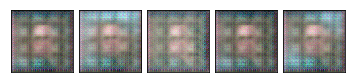

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.031060095629928744
Generator loss:     10.768140316009521


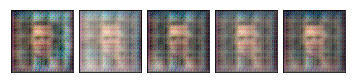

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.46it/s]
Discriminator loss: 0.03701003536801128
Generator loss:     9.96671858955832


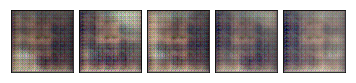

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.21it/s]
Discriminator loss: 0.07419460507876732
Generator loss:     11.037597824545468


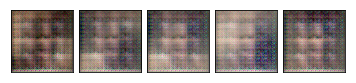

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.27it/s]
Discriminator loss: 0.05102672143017545
Generator loss:     7.939053535461426


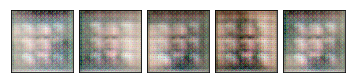

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.06it/s]
Discriminator loss: 0.02913084932986428
Generator loss:     8.136023661669563


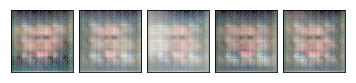

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.30it/s]
Discriminator loss: 0.05055817490553155
Generator loss:     9.42395440269919


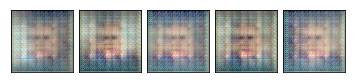

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.39it/s]
Discriminator loss: 0.023596799494150805
Generator loss:     9.703780202304616


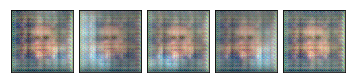

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.33it/s]
Discriminator loss: 0.030125460203956154
Generator loss:     10.451448833241182


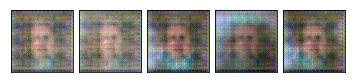

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.33it/s]
Discriminator loss: 0.02489055846543873
Generator loss:     9.535749435424805


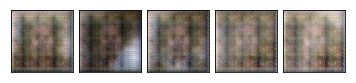

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.30it/s]
Discriminator loss: 0.03878423582543345
Generator loss:     10.403770643122057


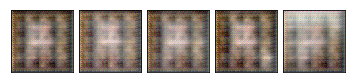

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.15it/s]
Discriminator loss: 0.05763880782486761
Generator loss:     11.011498226838953


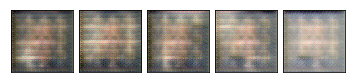

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.41it/s]
Discriminator loss: 0.047397276496185976
Generator loss:     11.10790460249957


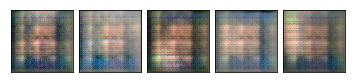

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.24it/s]
Discriminator loss: 0.04060671998954871
Generator loss:     11.847977918737074


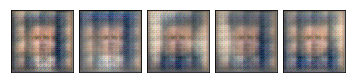

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.25it/s]
Discriminator loss: 0.013352618224042304
Generator loss:     8.680926827823415


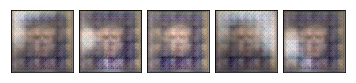

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.24it/s]
Discriminator loss: 0.04174211533630595
Generator loss:     9.133586546953987


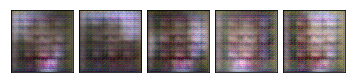

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.70it/s]
Discriminator loss: -0.013932405697072254
Generator loss:     8.309969986186308


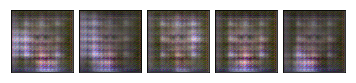

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.38it/s]
Discriminator loss: 0.04455560506047571
Generator loss:     11.780052858240465


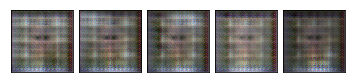

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.35it/s]
Discriminator loss: 0.042005222016835916
Generator loss:     11.220606944140266


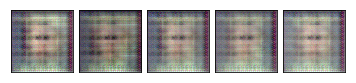

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.36it/s]
Discriminator loss: 0.044789898921461666
Generator loss:     9.957868211409625


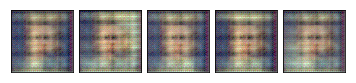

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.22it/s]
Discriminator loss: 0.026172436773777008
Generator loss:     9.146281046025893


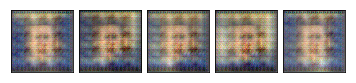

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.14it/s]
Discriminator loss: 0.019368157776839593
Generator loss:     7.496942379895379


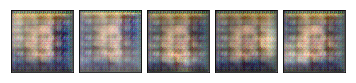

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
Discriminator loss: 0.0009296858573661131
Generator loss:     7.7319605771233055


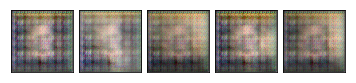

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.20it/s]
Discriminator loss: 0.005501605049871346
Generator loss:     7.319698866675882


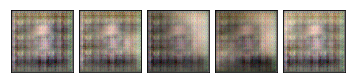

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.21it/s]
Discriminator loss: 0.03231088104931747
Generator loss:     8.491457995246439


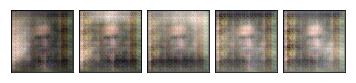

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.05it/s]
Discriminator loss: 0.02547282583135016
Generator loss:     9.01593261606553


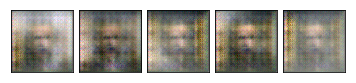

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.00it/s]
Discriminator loss: 0.03672037846134866
Generator loss:     8.19250634137322


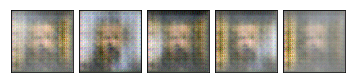

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: -0.002439247608623084
Generator loss:     7.089772673214183


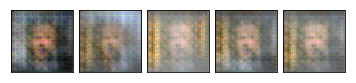

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.041782958871301484
Generator loss:     7.825737644644344


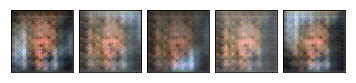

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.03502945229411125
Generator loss:     11.003360159256879


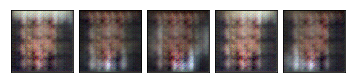

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.96it/s]
Discriminator loss: 0.03814027231077061
Generator loss:     9.721833565655876


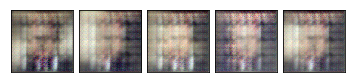

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.022525475908289936
Generator loss:     8.795534947339226


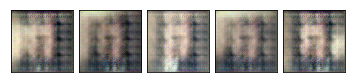

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.88it/s]
Discriminator loss: 0.05614198831950917
Generator loss:     12.800697354709401


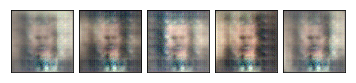

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.84it/s]
Discriminator loss: 0.02559424312237431
Generator loss:     14.83996228610768


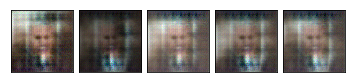

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.86it/s]
Discriminator loss: 0.049784058047568094
Generator loss:     10.58527811835794


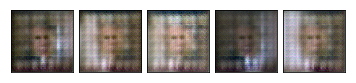

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.90it/s]
Discriminator loss: 0.04463378361919347
Generator loss:     8.552692413330078


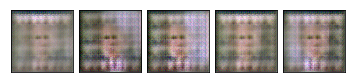

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.013734047739383052
Generator loss:     11.541373000425452


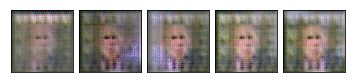

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.05255987528054153
Generator loss:     9.21201332877664


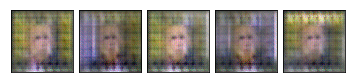

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.92it/s]
Discriminator loss: -0.007517707369783346
Generator loss:     10.403826489168054


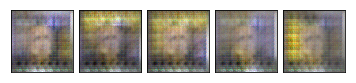

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.91it/s]
Discriminator loss: 0.023977108683217976
Generator loss:     10.500497144811293


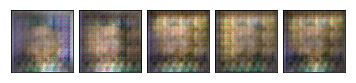

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.06533729909535717
Generator loss:     10.362654573777142


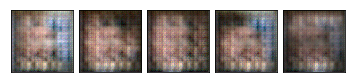

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.98it/s]
Discriminator loss: -0.03014084159889642
Generator loss:     16.25366485820097


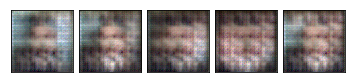

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.14it/s]
Discriminator loss: 0.08528617495561347
Generator loss:     11.503966443678912


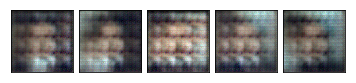

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.20it/s]
Discriminator loss: 0.0485588846837773
Generator loss:     10.73743449940401


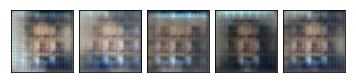

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.74it/s]
Discriminator loss: 0.02418605731252362
Generator loss:     10.099281254936667


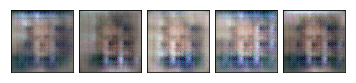

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.20it/s]
Discriminator loss: 0.031646001755314714
Generator loss:     9.45245922313017


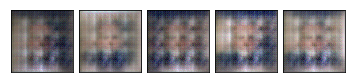

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.10it/s]
Discriminator loss: 0.02652003221652087
Generator loss:     7.922471411087933


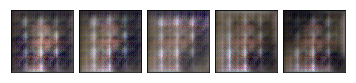

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.53it/s]
Discriminator loss: 0.08475906149867703
Generator loss:     10.272227764129639


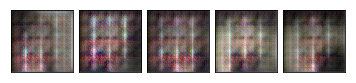

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.12it/s]
Discriminator loss: 0.06723713896730367
Generator loss:     9.634733873255113


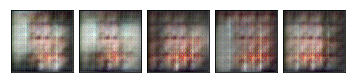

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.27it/s]
Discriminator loss: 0.07592289916732732
Generator loss:     10.159999286427217


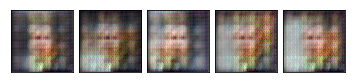

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.14it/s]
Discriminator loss: 0.034692903268424904
Generator loss:     7.952407612520106


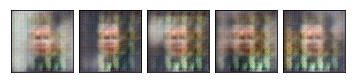

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.06it/s]
Discriminator loss: 0.09340258161811267
Generator loss:     11.900830437155332


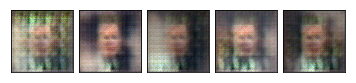

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.16it/s]
Discriminator loss: 0.14304472275954835
Generator loss:     10.162169736974379


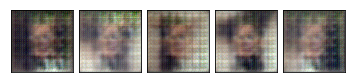

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.67it/s]
Discriminator loss: 0.036614916123011536
Generator loss:     9.434652889476103


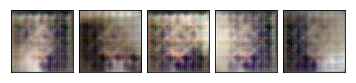

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.09it/s]
Discriminator loss: 0.10977952669867698
Generator loss:     7.391819813672234


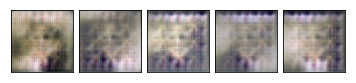

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.18it/s]
Discriminator loss: 0.0950633420554154
Generator loss:     9.348790112663718


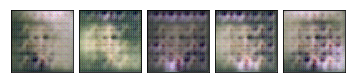

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.17it/s]
Discriminator loss: 0.03516111479086034
Generator loss:     9.174052434809068


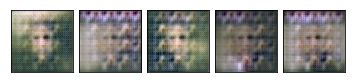

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.01it/s]
Discriminator loss: 0.042099163922316885
Generator loss:     7.89229404225069


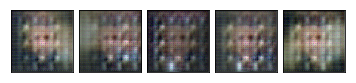

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.03it/s]
Discriminator loss: 0.026527422370717806
Generator loss:     8.674463945276598


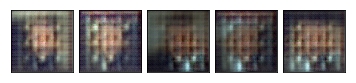

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.10it/s]
Discriminator loss: 0.014413932557491696
Generator loss:     8.634821246652042


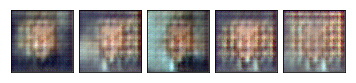

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:03<00:00,  6.03it/s]
Discriminator loss: 0.03635896649211645
Generator loss:     8.053174355450798


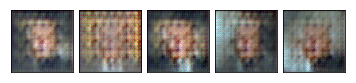

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


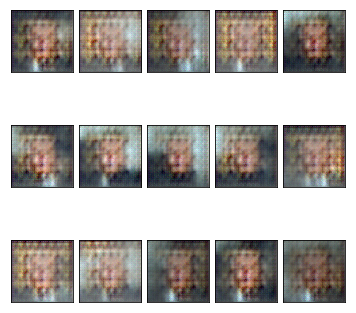

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


The gradients are maintained during generator update (feeding and backpropogation), and discarded during discriminator update hen sampling
fake data with the generator.

There is no need to calculate gradients for the generator when we are updating the discriminator. In this case we use
the generator to sample fake data to train the discriminator and not to train the generator, therefore we should not accumulate gradients
for this operation.

In the other hand, when we update the generator, we use the generator sample to forward and backpropogate to update the generator paremeters,
therefore, in this case maintaining the gradients is mandatory to train the generator.


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


1. No since the discriminator can be fooled by the generator while the generator generate good fakes. This that the generator is good doesn't
say the discriminator is also good to distinguish between fake and real data.

2. This that the generator loss decrease mean that the generator is performing better, generating better and better fakes. If in this case 
the discriminator loss stay const, this mean that the disriminator is really good trained (in case loss is small), even when feeding it
with better and better "fakes", it still able to distinguish with same accuracy. 



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


In my implimintation images from VAE looks better compared to images from GAN. Images from GAN looks more noisy and not smooth.

I expected the GAN give better results, therefore this can be architecture issue.
